In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
#import cmsisdsp as dsp
import random

import sys
sys.path.append('/home/mat/dev/cached_dilated_causal_convolutions/') 

from cmsisdsp_py_version.block import Block
from cmsisdsp_py_version.keras_model import create_dilated_model, create_strided_model
from cmsisdsp_py_version.cached_block_model import CachedBlockModel, Regression
from cmsisdsp_py_version.rolling_cache import RollingCache


In [2]:
def parse(fname):
    df_w = pd.read_csv(fname, sep=' ', names=['tri', 'w0', 'w1'])
    df_w['n'] = range(len(df_w))
    df_l = df_w.melt(id_vars='n', value_vars=['tri', 'w0', 'w1'])
    return df_w, df_l

tsr_df_w, tsr_df_l = parse('../datalogger_firmware/data/2d_embed/32kHz/tri_sine_ramp.ssv')
tsz_df_w, tsz_df_l = parse('../datalogger_firmware/data/2d_embed/32kHz/tri_squ_zigzag.ssv')

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

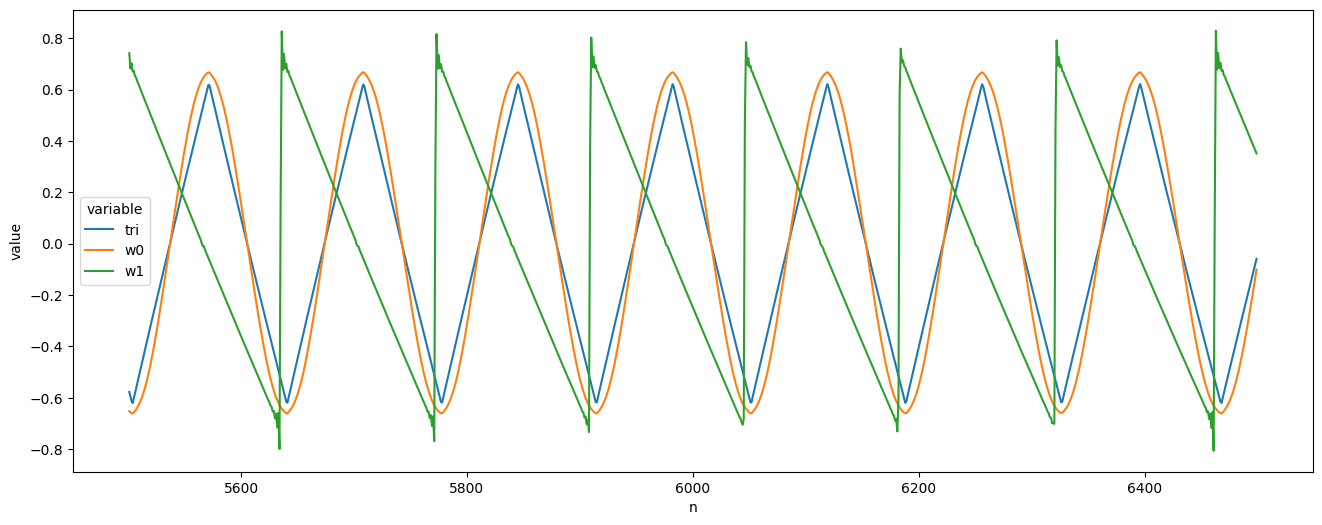

In [3]:
plt.figure(figsize=(16, 6))
offset = 5500
width = 1000
df = tsr_df_l
window = (df['n']>offset) & (df['n']<offset+width)
sns.lineplot(df[window], x='n', y='value', hue='variable')

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

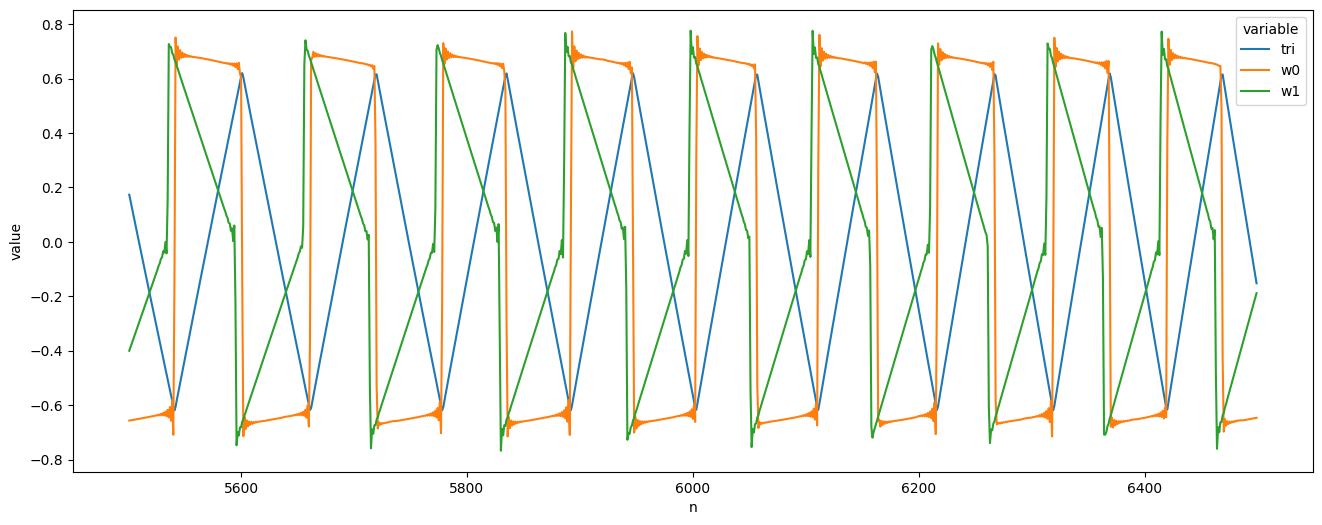

In [4]:
plt.figure(figsize=(16, 6))
offset = 5500
width = 1000
df = tsz_df_l
window = (df['n']>offset) & (df['n']<offset+width)
sns.lineplot(df[window], x='n', y='value', hue='variable')

we want to rebuild the dataset from tri, sine, ramp and tri, square, zigzag
to (embed0, embed1, tri) -> one of the other waves


In [40]:
data = tsr_df_w.to_numpy().astype(np.float32)

tri_to = {}
tri_to['sine'] = {}
tri_to['sine']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['sine']['x'][:,0] = 0  # x2
tri_to['sine']['x'][:,1] = 0  # x3
tri_to['sine']['x'][:,2] = data[:,0] # triangle
tri_to['sine']['y'] = np.expand_dims(data[:,1], -1) # sine

tri_to['ramp'] = {}
tri_to['ramp']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['ramp']['x'][:,0] = 0  # x2
tri_to['ramp']['x'][:,1] = 1  # x3
tri_to['ramp']['x'][:,2] = data[:,0] # triangle
tri_to['ramp']['y'] = np.expand_dims(data[:,2], -1) # ramp

data = tsz_df_w.to_numpy().astype(np.float32)

tri_to['square'] = {}
tri_to['square']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['square']['x'][:,0] = 1  # x2
tri_to['square']['x'][:,1] = 0  # x3
tri_to['square']['x'][:,2] = data[:,0] # triangle
tri_to['square']['y'] = np.expand_dims(data[:,1], -1) # square

tri_to['zigzag'] = {}
tri_to['zigzag']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['zigzag']['x'][:,0] = 1  # x2
tri_to['zigzag']['x'][:,1] = 1  # x3
tri_to['zigzag']['x'][:,2] = data[:,0] # triangle
tri_to['zigzag']['y'] = np.expand_dims(data[:,2], -1) # zigzag


In [41]:
def split_train_val_test(d):
    assert 'x' in d
    assert 'y' in d
    assert len(d['x']) == len(d['y'])
    val_test_split_size = int(len(d['x']) * 0.1)  # 10% for val and test
    d['train'] = {}
    d['validate'] = {}
    d['test'] = {}
    for xy in ['x', 'y']:                
        d['train'][xy] = d[xy][:-2*val_test_split_size]        
        d['validate'][xy] = d[xy][-2*val_test_split_size:-val_test_split_size]        
        d['test'][xy] = d[xy][-val_test_split_size:]
        d.pop(xy)

for wave in ['sine', 'ramp', 'square', 'zigzag']:
    split_train_val_test(tri_to[wave])

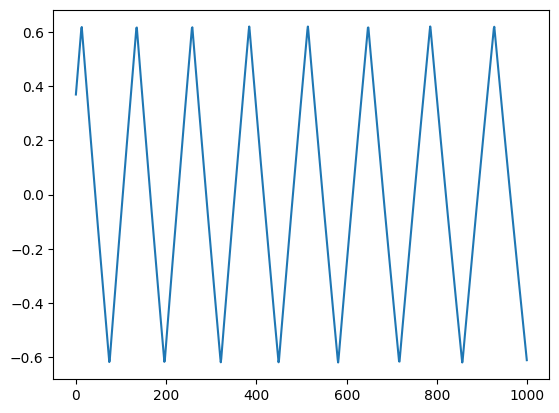

In [14]:
plt.plot(data[:,0][1000:2000])

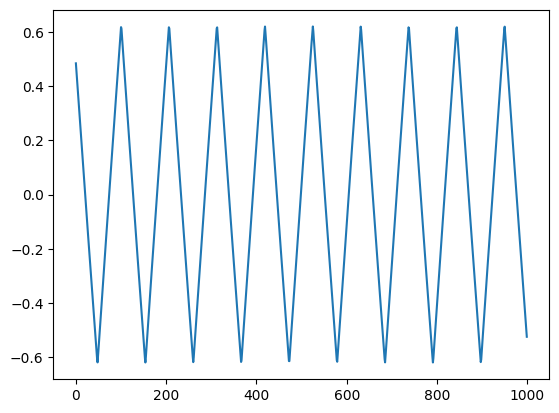

In [16]:
plt.plot(tri_to['ramp']['train']['x'][:,2][1000:2000])

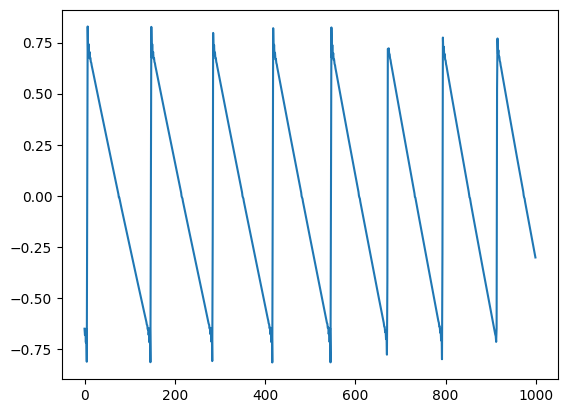

In [17]:
plt.plot(tri_to['ramp']['validate']['y'][1000:2000])

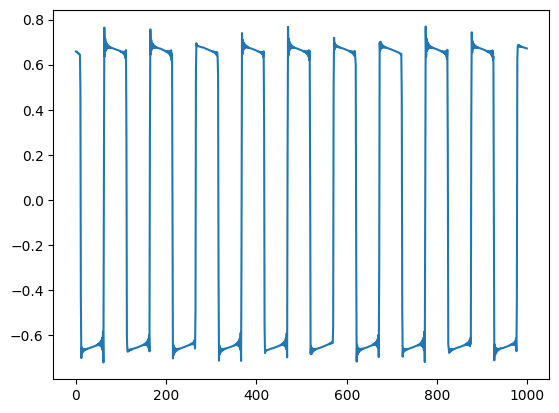

In [18]:
plt.plot(tri_to['square']['test']['y'][1000:2000])

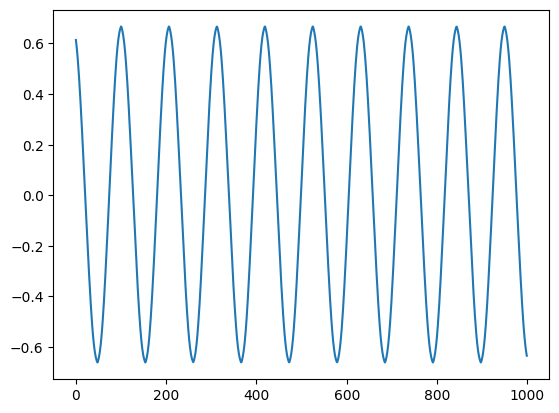

In [19]:
plt.plot(tri_to['sine']['train']['y'][1000:2000])

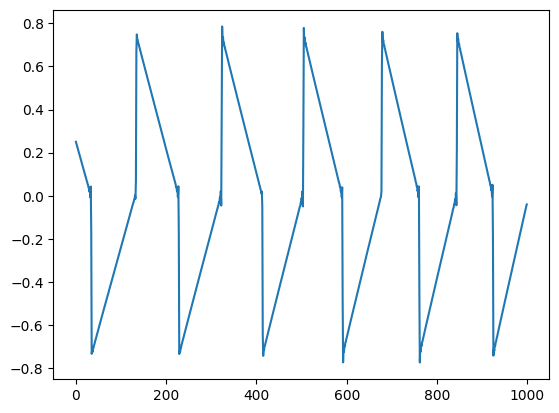

In [20]:
plt.plot(tri_to['zigzag']['validate']['y'][1000:2000])

In [21]:
IN_D = 3    # 2d embedding, (0,1) and core triangle
OUT_D = 1   # output wave

# kernel size and implied dilation rate
K = 4                

# filters for Nth layer Kx1 and 1x1 convs
# [4, 3, 8, 8] @ 32kHz => 72%
# [4, 8, 8, 8] @ 32kHz => 82%
# [4, 8, 8, 12] @ 32kHz => 93%
# [8, 8, 8, 8] @ 32kHz => TOO MUCH
# [4, 4, 4] @ 96kHz => too much :/
# [2, 2, 4] @ 96kHz => too much :/
# [2, 2, 2] @ 96kHz => too much :/

FILTER_SIZES = [4, 8, 8, 12]

RECEPTIVE_FIELD_SIZE = K**len(FILTER_SIZES)

TEST_SEQ_LEN = RECEPTIVE_FIELD_SIZE
TRAIN_SEQ_LEN = RECEPTIVE_FIELD_SIZE * 10

print("RECEPTIVE_FIELD_SIZE", RECEPTIVE_FIELD_SIZE)
print("TRAIN_SEQ_LEN", TRAIN_SEQ_LEN)
print("TEST_SEQ_LEN", TEST_SEQ_LEN)

RECEPTIVE_FIELD_SIZE 256
TRAIN_SEQ_LEN 2560
TEST_SEQ_LEN 256


In [27]:
def create_configured_keras_model(seq_len, all_outputs):
    return create_dilated_model(
        seq_len, in_d=IN_D, filter_sizes=FILTER_SIZES,
        kernel_size=K, out_d=OUT_D,
        all_outputs=all_outputs)

In [28]:
train_model = create_configured_keras_model(TRAIN_SEQ_LEN, all_outputs=False)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2560, 3)]         0         
                                                                 
 c0a (Conv1D)                (None, 2560, 4)           52        
                                                                 
 c0b (Conv1D)                (None, 2560, 4)           20        
                                                                 
 c1a (Conv1D)                (None, 2560, 8)           136       
                                                                 
 c1b (Conv1D)                (None, 2560, 8)           72        
                                                                 
 c2a (Conv1D)                (None, 2560, 8)           264       
                                                                 
 c2b (Conv1D)                (None, 2560, 8)           72  

In [29]:
# strided_variant = create_strided_model(
#         RECEPTIVE_FIELD_SIZE, in_d=IN_D, filter_sizes=FILTER_SIZES,
#         kernel_size=K, out_d=OUT_D)
# strided_variant.set_weights(train_model.get_weights())

In [30]:
# we want to ignore the first RECEPTIVE_FIELD_SIZE elements of the loss since they 
# have been fed with left padded data

mask = np.concatenate([np.zeros(RECEPTIVE_FIELD_SIZE), 
                       np.ones(TRAIN_SEQ_LEN-RECEPTIVE_FIELD_SIZE)])
mask = tf.convert_to_tensor(mask.astype(np.float32))

def masked_mse(y_true, y_pred):    
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return tf.multiply(mse, mask)    


In [31]:
from tensorflow.keras.optimizers import Adam

def dataset_from(x, y, s):
    def gen():
        idxs = list(range(len(x)-TRAIN_SEQ_LEN-1))  # ~1.3M
        random.Random(1337).shuffle(idxs)
        if s == 'train':            
            idxs = idxs[:200_000]
        else:
            idxs = idxs[:50_000]
        for i in idxs:
            yield x[i:i+TRAIN_SEQ_LEN], y[i+1:i+1+TRAIN_SEQ_LEN]
                
    ds = tf.data.Dataset.from_generator(
        gen, output_signature=(tf.TensorSpec(shape=(TRAIN_SEQ_LEN, IN_D), dtype=tf.float32),
                               tf.TensorSpec(shape=(TRAIN_SEQ_LEN, OUT_D), dtype=tf.float32)))
    return ds

def datasets_for_split(s):
    return  [
        dataset_from(tri_to[wave][s]['x'], tri_to[wave][s]['y'], s) #.cache() #filename=f"tf_data_cache_{wave}")
        for wave in ['sine', 'ramp', 'square', 'zigzag']  
    ] 
    
train_ds = tf.data.Dataset.sample_from_datasets(datasets_for_split('train'))
train_ds = train_ds.batch(128).prefetch(tf.data.AUTOTUNE)

validate_ds = tf.data.Dataset.sample_from_datasets(datasets_for_split('validate'))
validate_ds = validate_ds.batch(128).prefetch(tf.data.AUTOTUNE)

def scheduler(epoch, lr):   
    if epoch <= 5:
        return 1e-3
    elif epoch <= 10:
        return 1e-4
    else:
        return 1e-5
sch_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

train_model.compile(Adam(1e-3), loss=masked_mse)
train_model.fit(train_ds, 
                validation_data=validate_ds,
                callbacks=[sch_callback],
                epochs=15)

Epoch 1/15
6250/6250 [==============================] - 77s 12ms/step - loss: 0.0092 - val_loss: 0.0059 - lr: 0.0010
Epoch 2/15
6250/6250 [==============================] - 75s 12ms/step - loss: 0.0017 - val_loss: 0.0084 - lr: 0.0010
Epoch 3/15
 495/6250 [=>............................] - ETA: 55s - loss: 0.0016

KeyboardInterrupt: 

In [62]:
# train_model.save("trained_models/all_three")

# check against test data


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Figure size 640x480 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

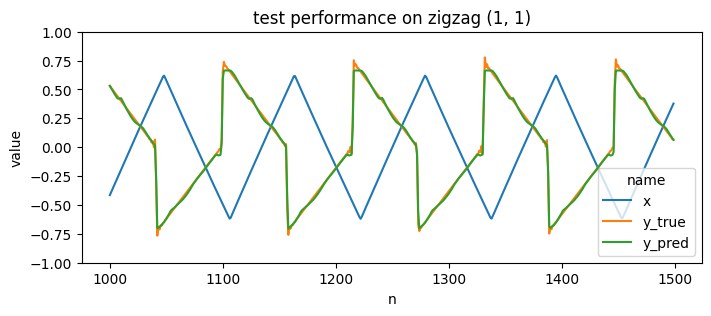

In [42]:
def wave_coords(wave):
    return {'sine': '(0, 0)', 'ramp': '(0, 1)',
            'square': '(1, 0)', 'zigzag': '(1, 1)' }[wave]

for wave in ['sine', 'ramp', 'square', 'zigzag']:
        
    test_records = []
    for i in range(1000, 1500):
        test_seq = tri_to[wave]['test']['x'][i:i+TRAIN_SEQ_LEN]
        test_seq = np.expand_dims(test_seq, 0)  # single element batch
        
        y_true = tri_to[wave]['test']['y'][i+TRAIN_SEQ_LEN]
                
        y_pred = train_model(test_seq).numpy()
        y_pred = y_pred[0,-1,:]  # train model gives all steps, we just want last
        
        for out_c in range(1):
            test_records.append((i, out_c, 'x', test_seq[0,-1,2])) 
            test_records.append((i, out_c, 'y_true', y_true[out_c]))
            test_records.append((i, out_c, 'y_pred', y_pred[out_c]))
        
    test_df = pd.DataFrame(test_records, columns=['n', 'c', 'name', 'value'])

    plt.clf()
    plt.figure(figsize=(8, 3))
    ax = sns.lineplot(data=test_df[test_df['c']==0], x='n', y='value', hue='name')
    ax.set(title=f"test performance on {wave} {wave_coords(wave)}")
    ax.set_ylim(-1, 1)
    plt.savefig(f"/tmp/test_{wave}.png")


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Figure size 640x480 with 0 Axes>

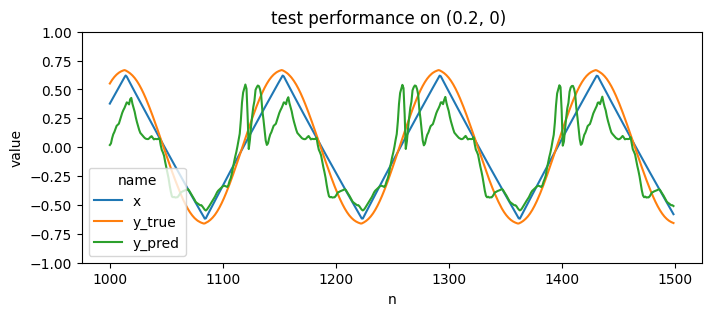

In [45]:
for wave in ['sine']:   # though we'll overridde x2 and x3
        
    test_records = []
    for i in range(1000, 1500):
        test_seq = tri_to[wave]['test']['x'][i:i+TRAIN_SEQ_LEN]
        test_seq = np.expand_dims(test_seq, 0)  # single element batch

        test_seq[:,:,0] = 0.2  # override x2
        test_seq[:,:,1] = 0.0  # override x3
        
        y_true = tri_to[wave]['test']['y'][i+TRAIN_SEQ_LEN]
                
        y_pred = train_model(test_seq).numpy()
        y_pred = y_pred[0,-1,:]  # train model gives all steps, we just want last
        
        for out_c in range(1):
            test_records.append((i, out_c, 'x', test_seq[0,-1,2])) 
            test_records.append((i, out_c, 'y_true', y_true[out_c]))
            test_records.append((i, out_c, 'y_pred', y_pred[out_c]))
        
    test_df = pd.DataFrame(test_records, columns=['n', 'c', 'name', 'value'])

    plt.clf()
    plt.figure(figsize=(8, 3))
    ax = sns.lineplot(data=test_df[test_df['c']==0], x='n', y='value', hue='name')
    ax.set(title=f"test performance on (0.2, 0) ")
    ax.set_ylim(-1, 1)
    plt.savefig(f"/tmp/test_inbetween.png")


## generate code

hacktastically generate some blocks of c++ code for the inference

In [64]:
# 8 => 3 conv blocks, 10 => 4 conv blocks
assert len(train_model.layers) in [8, 10], len(train_model.layers)

# layer[0] is input

blocks = [
    Block(
        c1_kernel = train_model.layers[1].weights[0].numpy(),
        c1_bias = train_model.layers[1].weights[1].numpy(),
        c2_kernel = train_model.layers[2].weights[0].numpy(),
        c2_bias = train_model.layers[2].weights[1].numpy(),
    ),
    Block(
        c1_kernel = train_model.layers[3].weights[0].numpy(),
        c1_bias = train_model.layers[3].weights[1].numpy(),
        c2_kernel = train_model.layers[4].weights[0].numpy(),
        c2_bias = train_model.layers[4].weights[1].numpy(),
    ),
    Block(
        c1_kernel = train_model.layers[5].weights[0].numpy(),
        c1_bias = train_model.layers[5].weights[1].numpy(),
        c2_kernel = train_model.layers[6].weights[0].numpy(),
        c2_bias = train_model.layers[6].weights[1].numpy(),
    ),
]

if len(train_model.layers) == 10:
    blocks.append(
        Block(
            c1_kernel = train_model.layers[7].weights[0].numpy(),
            c1_bias = train_model.layers[7].weights[1].numpy(),
            c2_kernel = train_model.layers[8].weights[0].numpy(),
            c2_bias = train_model.layers[8].weights[1].numpy(),
        ))

regression = Regression(
    weights=train_model.layers[-1].weights[0].numpy()[0],
    biases=train_model.layers[-1].weights[1].numpy()   
)

# create CachedBlockModel since it creates correct layer
# caches
cached_block_model = CachedBlockModel(
    blocks=blocks,
    input_feature_depth=IN_D,
    regression=regression
)      

with open("/tmp/model_defn.h", 'w') as f:
    cached_block_model.write_model_defn_h(f) #sys.stdout)

print("LGTM")

LGTM


In [20]:
m = create_strided_model(
        4**4, in_d=3, filter_sizes=[4, 8, 8, 12],
        kernel_size=4, out_d=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 3)]          0         
                                                                 
 c0a (Conv1D)                (None, 256, 4)            52        
                                                                 
 c0b (Conv1D)                (None, 256, 4)            20        
                                                                 
 c1a (Conv1D)                (None, 64, 8)             136       
                                                                 
 c1b (Conv1D)                (None, 64, 8)             72        
                                                                 
 c2a (Conv1D)                (None, 4, 8)              264       
                                                                 
 c2b (Conv1D)                (None, 4, 8)              72  